# Housing Prices
Unit 3 / Lesson 6 / Project 4

Using [this Kaggle data](https://www.kaggle.com/anthonypino/melbourne-housing-market) create a model to predict a house's value.
We want to be able to understand what creates value in a house, as though we were a real estate developer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Import data

In [2]:
# import data
PATH = ('assets\Melbourne_housing_FULL.csv')
raw_data = pd.read_csv(PATH, index_col=None)
df_raw = pd.DataFrame(raw_data)
df_raw.head()

PATH_clean = ('assets\Melbourne_housing_FULL_clean.csv')
clean_data = pd.read_csv(PATH_clean, index_col=0)
df_clean = pd.DataFrame(clean_data)
df_clean.head()

,Rooms,Price,Distance,Postcode,Lattitude,Longtitude,Propertycount,log_Price,h,t,...,Western_Victoria,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,high_price,low_price,Date
1,2,1480000.0,2.5,3067.0,-37.7996,144.9984,4019.0,14.207553,1.0,0.0,...,0.0,2.0,1.0,1.0,202.0,165.0,1960.0,0,0,2016-12-03
2,2,1035000.0,2.5,3067.0,-37.8079,144.9934,4019.0,13.849913,1.0,0.0,...,0.0,2.0,1.0,0.0,156.0,79.0,1900.0,0,0,2016-02-04
4,3,1465000.0,2.5,3067.0,-37.8093,144.9944,4019.0,14.197366,1.0,0.0,...,0.0,3.0,2.0,0.0,134.0,150.0,1900.0,0,0,2017-03-04
5,3,850000.0,2.5,3067.0,-37.7969,144.9969,4019.0,13.652993,1.0,0.0,...,0.0,3.0,2.0,1.0,94.0,165.0,1960.0,0,0,2017-03-04
6,4,1600000.0,2.5,3067.0,-37.8072,144.9941,4019.0,14.285515,1.0,0.0,...,0.0,3.0,1.0,2.0,120.0,142.0,2014.0,1,0,2016-06-04


### Content & Acknowledgements
This data was scraped from publicly available results posted every week from Domain.com.au, I've cleaned it as best I can, now it's up to you to make data analysis magic. The dataset includes Address, Type of Real estate, Suburb, Method of Selling, Rooms, Price, Real Estate Agent, Date of Sale and distance from C.B.D.

....Now with extra data including including property size, land size and council area, you may need to change your code!

Some Key Details
Suburb: Suburb

Address: Address

Rooms: Number of rooms

Price: Price in Australian dollars

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from CBD in Kilometres

Regionname: General Region (West, North West, North, North east ...etc)

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size in Metres

BuildingArea: Building Size in Metres

YearBuilt: Year the house was built

CouncilArea: Governing council for the area

Lattitude: Self explanitory

Longtitude: Self explanitory

## EDA
Let's explore the data and get an idea of what we're working with.

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

In [4]:
df_raw.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34856.000000,34856.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000
mean,3.031012,1.050173e+06,11.184929,3116.062859,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306
std,0.969933,6.414671e+05,6.788892,109.023903,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


0          NaN
1    1480000.0
2    1035000.0
3          NaN
4    1465000.0
Name: Price, dtype: float64

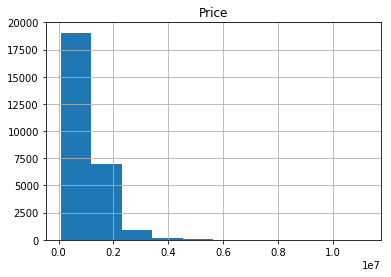

In [5]:
# view price data
display(df_raw.Price.head())
df_raw.Price.dropna().hist()
plt.title('Price');

Let's see if we can log transform the Price data to create a distribution we can work with.

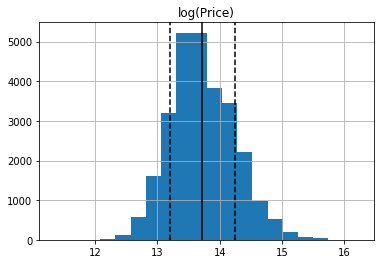

In [6]:
# log transform price data
df_raw['log_Price'] = np.log1p(df_raw.Price.dropna())

log_price_mean = df_raw['log_Price'].mean()
log_price_std = df_raw['log_Price'].std()

# view log(price) data
df_raw.log_Price.hist(bins=20)
plt.axvline((log_price_mean+log_price_std), color='k', linestyle='--')
plt.axvline((log_price_mean-log_price_std), color='k', linestyle='--')
plt.axvline(log_price_mean, color='k', linestyle='-')
plt.title('log(Price)');

That's much better.

## Data Cleaning

In [7]:
# view missing data
display(df_raw.shape)
display(df_raw.dropna().shape)

(34857, 22)

(8887, 22)

It looks like our dataset has a ton of missing values, approximately 75%.
Let's see if we can clean some of this up by dropping unnecessary features filling in some NaNs.
We'll also have to work with our dtypes, we have 8 instances of dtype = object that we'll have to correct.

In [8]:
# view features
df_raw.columns.values

# view sum of NaN values if
# all missing Price values are dropped
#df_raw.dropna(subset=['Price']).isna().sum()

# view sum of NaN values
df_raw.isna().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
log_Price         7610
dtype: int64

It looks like most of our missing data is from the columns 'Price' (and consequentially 'log_Price'), 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuild', 'Lattitude', and 'Longitude'.
The rest of the columns with missing data should be easy to infer or input based on the rest of the data present.

The missing 'Price' data will be the most troublesome, as it is the variable we hope to predict. We could input the missing values with the median Price value, or the median Price value of homes in the similar class.
For example we could input the median price of all homes, or the median price homes with a similar number of rooms.
Either way, it will skew the data and our model.
We could drop the missing values, but we would loose ~20% of our dataset.

Let's start with filling in our other missing data and see what we're left with.
First, though, we'll define price ranges for low, median, and high priced homes.
These ranges will [hopefully] give us a more intuitive idea when inputting NaN values.

### Set categorical price values
#### Price ranges

In [9]:
# define 'high price' and 'low price' binary features
df_raw['high_price'] = np.where(
    df_raw['log_Price'] > (log_price_mean+log_price_std), 1, 0
)

df_raw['low_price'] = np.where(
    df_raw['log_Price'] < (log_price_mean-log_price_std), 1, 0
)

display(df_raw['high_price'].value_counts())
df_raw['low_price'].value_counts()

0    30493
1     4364
Name: high_price, dtype: int64

0    30741
1     4116
Name: low_price, dtype: int64

#### One-Hot encoding

The features 'Suburb', 'Address', and 'SellerG' have far too many unique values to be helpful.
So we will just drop those columns.

'Type', 'Method', and 'Regionname' we can convert with one-hot encoding to a new set of features.
If we do that, we can also drop 'CouncilArea' as it is a more specific (and likely directly correlated!) version of the 'Regionname' feature (for example, 'Yarra City Council' will only be in the 'Northen Metropolitan' region).

Lastly, we can convert 'Date' to a datetime format.

In [10]:
# drop features
drop_list = ['Suburb', 'Address', 'SellerG', 'CouncilArea']
df_raw = df_raw.drop(drop_list, axis=1)

df_raw.head()

,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,log_Price,high_price,low_price
0,2,h,NaN,SS,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,-37.8014,144.9958,Northern Metropolitan,4019.0,NaN,0,0
1,2,h,1480000.0,S,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,-37.7996,144.9984,Northern Metropolitan,4019.0,14.207553,0,0
2,2,h,1035000.0,S,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,Northern Metropolitan,4019.0,13.849913,0,0
3,3,u,NaN,VB,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,-37.8114,145.0116,Northern Metropolitan,4019.0,NaN,0,0
4,3,h,1465000.0,SP,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,Northern Metropolitan,4019.0,14.197366,0,0


In [11]:
df_raw[['Type', 'Method', 'Regionname']].isna().sum()

Type          0
Method        0
Regionname    3
dtype: int64

In [12]:
# Regionname has NaN values,
# so we'll have to deal with those
df_raw = df_raw.dropna(subset=['Type', 'Method', 'Regionname'], axis=0)

In [13]:
# one-hot encoding
# set sparse=False to return an array
cat_encoder = OneHotEncoder(sparse=False)
df_raw_type_reshaped = df_raw['Type'].values.reshape(-1,1)
df_raw_type_1hot = cat_encoder.fit_transform(df_raw_type_reshaped)
categories = cat_encoder.categories_
df_raw_type_1hot = pd.DataFrame(df_raw_type_1hot, columns=categories)

In [14]:
# concat 1hot DataFrame w/ df_na
# reset index of df_na and concat
df_raw = df_raw.reset_index().drop('index', axis=1)
df_raw = pd.concat([df_raw, df_raw_type_1hot], axis=1)
df_raw.head()

,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,...,Lattitude,Longtitude,Regionname,Propertycount,log_Price,high_price,low_price,"(h,)","(t,)","(u,)"
0,2,h,NaN,SS,3/09/2016,2.5,3067.0,2.0,1.0,1.0,...,-37.8014,144.9958,Northern Metropolitan,4019.0,NaN,0,0,1.0,0.0,0.0
1,2,h,1480000.0,S,3/12/2016,2.5,3067.0,2.0,1.0,1.0,...,-37.7996,144.9984,Northern Metropolitan,4019.0,14.207553,0,0,1.0,0.0,0.0
2,2,h,1035000.0,S,4/02/2016,2.5,3067.0,2.0,1.0,0.0,...,-37.8079,144.9934,Northern Metropolitan,4019.0,13.849913,0,0,1.0,0.0,0.0
3,3,u,NaN,VB,4/02/2016,2.5,3067.0,3.0,2.0,1.0,...,-37.8114,145.0116,Northern Metropolitan,4019.0,NaN,0,0,0.0,0.0,1.0
4,3,h,1465000.0,SP,4/03/2017,2.5,3067.0,3.0,2.0,0.0,...,-37.8093,144.9944,Northern Metropolitan,4019.0,14.197366,0,0,1.0,0.0,0.0


In [15]:
# one-hot encode 'Method' feature
df_raw_meth_reshaped = df_raw['Method'].values.reshape(-1,1)
df_raw_meth_1hot = cat_encoder.fit_transform(df_raw_meth_reshaped)
categories = cat_encoder.categories_
df_raw_meth_1hot = pd.DataFrame(df_raw_meth_1hot, columns=categories)

# concat 1hot DataFrame w/ df_na
df_raw = pd.concat([df_raw, df_raw_meth_1hot], axis=1)
df_raw.head()

,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,...,"(u,)","(PI,)","(PN,)","(S,)","(SA,)","(SN,)","(SP,)","(SS,)","(VB,)","(W,)"
0,2,h,NaN,SS,3/09/2016,2.5,3067.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,h,1480000.0,S,3/12/2016,2.5,3067.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,h,1035000.0,S,4/02/2016,2.5,3067.0,2.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,u,NaN,VB,4/02/2016,2.5,3067.0,3.0,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3,h,1465000.0,SP,4/03/2017,2.5,3067.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
# one-hot encode 'Regionname' feature
df_raw_reg_reshaped = df_raw['Regionname'].values.reshape(-1,1)
df_raw_reg_1hot = cat_encoder.fit_transform(df_raw_reg_reshaped)
categories = cat_encoder.categories_
df_raw_reg_1hot = pd.DataFrame(df_raw_reg_1hot, columns=categories)

# concat 1hot DataFrame w/ df_na
df_raw = pd.concat([df_raw, df_raw_reg_1hot], axis=1)
df_raw.head()

,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,...,"(VB,)","(W,)","(Eastern Metropolitan,)","(Eastern Victoria,)","(Northern Metropolitan,)","(Northern Victoria,)","(South-Eastern Metropolitan,)","(Southern Metropolitan,)","(Western Metropolitan,)","(Western Victoria,)"
0,2,h,NaN,SS,3/09/2016,2.5,3067.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,h,1480000.0,S,3/12/2016,2.5,3067.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,h,1035000.0,S,4/02/2016,2.5,3067.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,u,NaN,VB,4/02/2016,2.5,3067.0,3.0,2.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3,h,1465000.0,SP,4/03/2017,2.5,3067.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_raw.isna().sum()

Rooms                                0
Type                                 0
Price                             7610
Method                               0
Date                                 0
Distance                             0
Postcode                             0
Bedroom2                          8214
Bathroom                          8223
Car                               8725
Landsize                         11807
BuildingArea                     21112
YearBuilt                        19303
Lattitude                         7973
Longtitude                        7973
Regionname                           0
Propertycount                        0
log_Price                         7610
high_price                           0
low_price                            0
(h,)                                 0
(t,)                                 0
(u,)                                 0
(PI,)                                0
(PN,)                                0
(S,)                     

### Fill NaN values

In [18]:
# drop NaNs from target column(s)
df_na = df_raw.dropna(subset=['Price', 'log_Price'], axis=0)
df_na.isna().sum()

Rooms                                0
Type                                 0
Price                                0
Method                               0
Date                                 0
Distance                             0
Postcode                             0
Bedroom2                          6438
Bathroom                          6444
Car                               6821
Landsize                          9262
BuildingArea                     16588
YearBuilt                        15160
Lattitude                         6251
Longtitude                        6251
Regionname                           0
Propertycount                        0
log_Price                            0
high_price                           0
low_price                            0
(h,)                                 0
(t,)                                 0
(u,)                                 0
(PI,)                                0
(PN,)                                0
(S,)                     

In [19]:
# find our features with dtype == object
objects = []

for i in df_raw.columns.values:
    if df_raw[i].dtype == 'O':
        objects.append(str(i))

df_na = df_na.drop(objects, axis=1)

df_na.isna().sum()

Rooms                                0
Price                                0
Distance                             0
Postcode                             0
Bedroom2                          6438
Bathroom                          6444
Car                               6821
Landsize                          9262
BuildingArea                     16588
YearBuilt                        15160
Lattitude                         6251
Longtitude                        6251
Propertycount                        0
log_Price                            0
high_price                           0
low_price                            0
(h,)                                 0
(t,)                                 0
(u,)                                 0
(PI,)                                0
(PN,)                                0
(S,)                                 0
(SA,)                                0
(SN,)                                0
(SP,)                                0
(SS,)                    

In [20]:
# drop regional data
cols = ['Bedroom2', 'Bathroom', 'Car',
        'Landsize','BuildingArea', 'YearBuilt',
        'high_price', 'low_price']
df_num = df_na[cols]

# check nulls
df_num.isna().sum()

Bedroom2         6438
Bathroom         6444
Car              6821
Landsize         9262
BuildingArea    16588
YearBuilt       15160
high_price          0
low_price           0
dtype: int64

In [21]:
# fill NaN values by median of price category
df_num.loc[df_num['high_price']==1] = df_num.loc[
    df_num['high_price']==1].apply(lambda x: x.fillna(x.median()),axis=0)
df_num.loc[df_num['low_price']==1] = df_num.loc[
    df_num['low_price']==1].apply(lambda x: x.fillna(x.median()),axis=0)
df_num.loc[df_num['high_price' and 'low_price']==0] = df_num.loc[
    df_num['high_price' and 'low_price']==0].apply(lambda x: x.fillna(x.median()),axis=0)

df_num.isna().sum()

C:\Users\Aaron\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Bedroom2        0
Bathroom        0
Car             0
Landsize        0
BuildingArea    0
YearBuilt       0
high_price      0
low_price       0
dtype: int64

In [22]:
# concat filled NaNs w/ the rest of our data
df_na = pd.concat([df_na.drop(cols, axis=1), df_num], axis=1)
df_na.head()
df_na.isna().sum()

Rooms                               0
Price                               0
Distance                            0
Postcode                            0
Lattitude                        6251
Longtitude                       6251
Propertycount                       0
log_Price                           0
(h,)                                0
(t,)                                0
(u,)                                0
(PI,)                               0
(PN,)                               0
(S,)                                0
(SA,)                               0
(SN,)                               0
(SP,)                               0
(SS,)                               0
(VB,)                               0
(W,)                                0
(Eastern Metropolitan,)             0
(Eastern Victoria,)                 0
(Northern Metropolitan,)            0
(Northern Victoria,)                0
(South-Eastern Metropolitan,)       0
(Southern Metropolitan,)            0
(Western Met

In [23]:
# clean up columns from 1hot encoding
col_list = ['Rooms', 'Price', 'Distance', 'Postcode', 'Lattitude',
            'Longtitude', 'Propertycount', 'log_Price', 'h', 't', 'u',
            'PI', 'PN', 'S', 'SA', 'SN', 'SP', 'SS',
            'VB', 'W', 'Eastern_Metropolitan', 'Eastern_Victoria',
            'Northern_Metropolitan', 'Northern_Victoria',
            'South_Eastern_Metropolitan', 'Southern_Metropolitan',
            'Western_Metropolitan', 'Western_Victoria', 'Bedroom2',
            'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
            'high_price', 'low_price']
df_na.columns = col_list


In [24]:
reg_cols = ['Eastern_Metropolitan', 'Eastern_Victoria',
            'Northern_Metropolitan', 'Northern_Victoria',
            'South_Eastern_Metropolitan', 'Southern_Metropolitan',
            'Western_Metropolitan', 'Western_Victoria']

for i in reg_cols:
    df_na.loc[df_na[i]==1] = df_na.loc[
        df_na[i]==1].apply(lambda x: x.fillna(x.median()),axis=0)
    
df_na.isna().sum()

Rooms                         0
Price                         0
Distance                      0
Postcode                      0
Lattitude                     0
Longtitude                    0
Propertycount                 0
log_Price                     0
h                             0
t                             0
u                             0
PI                            0
PN                            0
S                             0
SA                            0
SN                            0
SP                            0
SS                            0
VB                            0
W                             0
Eastern_Metropolitan          0
Eastern_Victoria              0
Northern_Metropolitan         0
Northern_Victoria             0
South_Eastern_Metropolitan    0
Southern_Metropolitan         0
Western_Metropolitan          0
Western_Victoria              0
Bedroom2                      0
Bathroom                      0
Car                           0
Landsize

Now we've filled the NaN values.

### Convert to datetime

In [25]:
# convert Date feature to datetime
df_na['Date'] = df_raw['Date']
df_na['Date'].head()
df_na['Date'] = pd.to_datetime(df_na['Date'], errors='raise', dayfirst=1)
df_na['Date'].head()

1   2016-12-03
2   2016-02-04
4   2017-03-04
5   2017-03-04
6   2016-06-04
Name: Date, dtype: datetime64[ns]

In [26]:
# store clean data
df_clean = df_na
#df_clean.to_csv('assets\Melbourne_housing_FULL_clean.csv')

In [27]:
# check data
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27244 entries, 1 to 34853
Data columns (total 37 columns):
Rooms                         27244 non-null int64
Price                         27244 non-null float64
Distance                      27244 non-null float64
Postcode                      27244 non-null float64
Lattitude                     27244 non-null float64
Longtitude                    27244 non-null float64
Propertycount                 27244 non-null float64
log_Price                     27244 non-null float64
h                             27244 non-null float64
t                             27244 non-null float64
u                             27244 non-null float64
PI                            27244 non-null float64
PN                            27244 non-null float64
S                             27244 non-null float64
SA                            27244 non-null float64
SN                            27244 non-null float64
SP                            27244 non-null 

Excellent! Our data is clean, we have no missing values, and our dtypes are correct.
Let's check our data for correlation and then it will be ready to model.

## Feature Selection

### Check for correlation.
First, let's define our data and target value.
Then we can check for correlation and drop any features with over 90% correlation.

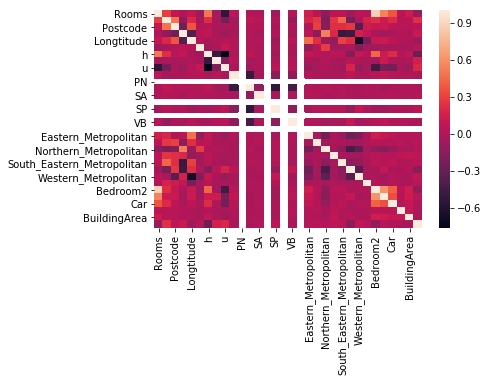

In [28]:
# define data and target
# drop our target value and derived values
# drop datetime as it likely won't help our model
drop_list = ['Price', 'log_Price', 'high_price', 'low_price', 'Date']
data = df_clean.drop(drop_list, axis=1)
target = df_clean['log_Price']

# plot a heatmap
sns.heatmap(data.corr());

In [29]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=4).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

display(data.shape)

# Drop correlated features 
for i in to_drop:
    data = data.drop(i, axis=1)

data.shape

(27244, 32)

(27244, 32)

It looks like our features aren't overly correlated.
Let's go ahead with modeling.

## Model Selection

In [30]:
# define training and test set
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42)

# scale X_train values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))

### Linear Regression

In [31]:
# determine which model to use
OLS = LinearRegression()
OLS.fit(X_train, y_train)
y_pred = OLS.predict(X_test)

# Display.
print('Linear Regression')
print('\nR-squared training set:')
print(OLS.score(X_train, y_train))

print('\nR-squared test set:')
print(OLS.score(X_test, y_test))

Linear Regression

R-squared training set:
0.7253244124054998

R-squared test set:
0.7287006774955719


### Linear Regression Scaled

In [32]:
# determine which model to use
OLS_scaled = LinearRegression()
OLS_scaled.fit(X_train_scaled, y_train)
y_pred = OLS_scaled.predict(X_test_scaled)

# Display.
print('Scaled Linear Regression')
print('\nR-squared training set:')
print(OLS_scaled.score(X_train_scaled, y_train))

print('\nR-squared test set:')
print(OLS_scaled.score(X_test_scaled, y_test))

Scaled Linear Regression

R-squared training set:
0.7252896176125594

R-squared test set:
0.7287869261634629


### Random Forest Regression

In [33]:
# determine which model to use
RF = RandomForestRegressor(n_estimators=10)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

# Display.
print('Random Forest Regressor')
print('\nR-squared training set:')
print(RF.score(X_train, y_train))

print('\nR-squared test set:')
print(RF.score(X_test, y_test))

Random Forest Regressor

R-squared training set:
0.9714028491346186

R-squared test set:
0.8723380703913589


### Random Forest Regressor Scaled

In [34]:
# determine which model to use
RF_scaled = RandomForestRegressor(n_estimators=10)
RF_scaled.fit(X_train_scaled, y_train)
y_pred = RF_scaled.predict(X_test_scaled)

# Display.
print('Scaled Random Forest Regressor')
print('\nR-squared training set:')
print(RF_scaled.score(X_train_scaled, y_train))

print('\nR-squared test set:')
print(RF_scaled.score(X_test_scaled, y_test))

Scaled Random Forest Regressor

R-squared training set:
0.9709659440725604

R-squared test set:
0.8757639270512025


### Ridge Regression

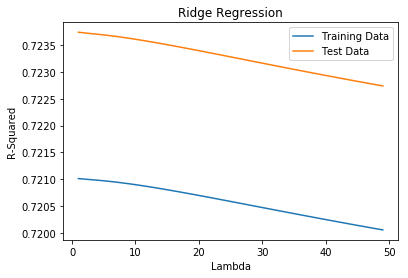

In [35]:
# define empty list
alphas = []
train_scores = []
test_scores = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridge = Ridge(alpha=lambd, fit_intercept=False)
    ridge.fit(X_train, y_train)
    alphas.append(lambd)
    train_scores.append(ridge.score(X_train, y_train))
    test_scores.append(ridge.score(X_test, y_test))

plt.plot(alphas, train_scores, label='Training Data')
plt.plot(alphas, test_scores, label='Test Data')
plt.title('Ridge Regression')
plt.xlabel('Lambda')
plt.ylabel('R-Squared')
plt.legend()
plt.show();

In [36]:
# instantiate ridgeCV regression
alpha_list = range(1, 50, 2)
ridge = RidgeCV(alphas=alpha_list, cv=5)
ridge.fit(X_train, y_train)

# Display
print('Ridge Regression')
print('\nR-squared training set:')
print(ridge.score(X_train, y_train))

print('\nR-squared test set:')
print(ridge.score(X_test, y_test))

print('\nRidge regression alpha:')
print(ridge.alpha_)

Ridge Regression

R-squared training set:
0.7253207880765609

R-squared test set:
0.7286633507225171

Ridge regression alpha:
1


### Scaled Ridge Regression

In [37]:
# instantiate ridgeCV regression
alpha_list = range(1, 50, 2)
ridge_scaled = RidgeCV(alphas=alpha_list, cv=5)
ridge_scaled.fit(X_train_scaled, y_train)

# Display
print('Scaled Ridge Regression')
print('\nR-squared training set:')
print(ridge_scaled.score(X_train_scaled, y_train))

print('\nR-squared test set:')
print(ridge_scaled.score(X_test_scaled, y_test))

print('\nRidge regression alpha:')
print(ridge_scaled.alpha_)

Scaled Ridge Regression

R-squared training set:
0.7253202458474701

R-squared test set:
0.7286898899737332

Ridge regression alpha:
49


### Gradient Boosting Regressor

In [38]:
# determine which model to use
GBRT = GradientBoostingRegressor(max_depth=2, n_estimators=120)
GBRT.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred)
         for y_pred in GBRT.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

GBRT_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
GBRT_best.fit(X_train, y_train)
y_pred = GBRT_best.predict(X_test)

# Display
print('Gradient Boosting Regressor')
print('\nR-squared training set:')
print(GBRT_best.score(X_train, y_train))

print('\nR-squared test set:')
print(GBRT_best.score(X_test, y_test))

Gradient Boosting Regressor

R-squared training set:
0.8477013405566164

R-squared test set:
0.8472949130154893


### Gradient Boosting Regressor Scaled

In [39]:
# determine which model to use
GBRT_scaled = GradientBoostingRegressor(max_depth=2, n_estimators=120)
GBRT_scaled.fit(X_train_scaled, y_train)

errors = [mean_squared_error(y_test, y_pred)
         for y_pred in GBRT_scaled.staged_predict(X_test_scaled)]
best_n_estimators = np.argmin(errors)

GBRT_scaled_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
GBRT_scaled_best.fit(X_train_scaled, y_train)
y_pred = GBRT_scaled_best.predict(X_test_scaled)

# Display
print('Scaled Gradient Boosting Regressor')
print('\nR-squared training set:')
print(GBRT_scaled_best.score(X_train_scaled, y_train))

print('\nR-squared test set:')
print(GBRT_scaled_best.score(X_test_scaled, y_test))

Scaled Gradient Boosting Regressor

R-squared training set:
0.8477013405566165

R-squared test set:
0.8472949130154895


## Fine Tune Model

### Sample dataset
Sample 50% of training data for model optimization.

In [40]:
# sample training set to speed up parameter optimization
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_train, y_train, test_size=0.5, random_state=42)

### Parameter optimization

In [41]:
# define our parameter ranges
learning_rate=[0.01]
alpha=[0.01,0.03,0.05,0.1,0.3, 0.9]
n_estimators=[int(x) for x in np.linspace(start = 10, stop = 500, num = 4)]
max_depth=[int(x) for x in np.linspace(start = 3, stop = 15, num = 4)]
max_depth.append(None)
min_samples_split=[int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
min_samples_leaf=[int(x) for x in np.linspace(start = 1, stop = 4, num = 4)]
max_features=['auto', 'sqrt']

# Create the random grid
param_grid = {'learning_rate':learning_rate,
              'alpha':alpha,
              'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             }

print(param_grid)

# Initialize and fit the model.
model = GradientBoostingRegressor()
model = RandomizedSearchCV(model, param_grid, cv=3)
model.fit(X_train_sample, y_train_sample)

# get the best parameters
best_params = model.best_params_
print(best_params)

{'learning_rate': [0.01], 'alpha': [0.01, 0.03, 0.05, 0.1, 0.3, 0.9], 'n_estimators': [10, 173, 336, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 7, 11, 15, None], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3, 4]}
{'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 11, 'learning_rate': 0.01, 'alpha': 0.05}


In [42]:
# refit model with best parameters
model_best = GradientBoostingRegressor(**best_params)
model_best.fit(X_train, y_train)
y_pred = model_best.predict(X_test)

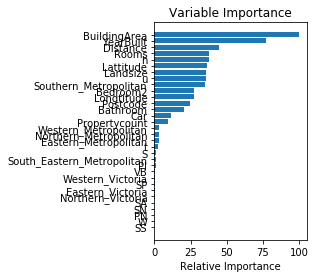

In [43]:
feature_importance = model_best.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.subplot(1,2,2)
plt.barh(pos, feature_importance[sorted_idx], align='center')

plt.yticks(pos, data.columns.values[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [44]:
# Display.
print('Optimized Gradient Boosting Regressor')
print('\nR-squared training set:')
print(model_best.score(X_train, y_train))
print('\nMean absolute error training set: ')
print(mean_absolute_error(y_train, model_best.predict(X_train)))
print('\nMean squared error training set: ')
print(mean_squared_error(y_train, model_best.predict(X_train)))

print('\n\nR-squared test set:')
print(model_best.score(X_test, y_test))
print('\nMean absolute error test set: ')
print(mean_absolute_error(y_test, y_pred))
print('\nMean squared error test set: ')
print(mean_squared_error(y_test, y_pred))

Optimized Gradient Boosting Regressor

R-squared training set:
0.9512026880418638

Mean absolute error training set: 
0.08425475481192844

Mean squared error training set: 
0.012981128060353349


R-squared test set:
0.9005276033730708

Mean absolute error test set: 
0.12290827621871302

Mean squared error test set: 
0.02708120268827605
